# Prediksi Tanaman dengan Decision Tree Manual


## Dataset: Crop Recommendation
Dataset berisi informasi tentang:
- N, P, K (Nitrogen, Phosphorus, Potassium)
- Temperature, Humidity, pH, Rainfall
- Label: Jenis tanaman yang direkomendasikan



In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('/Users/anargyaisadhimaheswara/Documents/Semester5/AI/PBL')
from modul_decisiontree import DecisionTreeClassifier
from manual_tree_visualization import ManualTreeVisualizer

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## Manual Implementations

Implementasi manual untuk fungsi-fungsi yang biasanya disediakan oleh sklearn.

In [ ]:
class ManualLabelEncoder:
    def __init__(self):
        self.classes_ = None
        self.class_to_index = {}
        self.index_to_class = {}
    
    def fit(self, y):
        self.classes_ = np.unique(y)
        self.class_to_index = {label: idx for idx, label in enumerate(self.classes_)}
        self.index_to_class = {idx: label for idx, label in enumerate(self.classes_)}
        return self
    
    def transform(self, y):
        return np.array([self.class_to_index[label] for label in y])
    
    def fit_transform(self, y):
        self.fit(y)
        return self.transform(y)
    
    def inverse_transform(self, y):
        return np.array([self.index_to_class[idx] for idx in y])


# Manual Train-Test Split
def manual_train_test_split(X, y, test_size=0.2, random_state=None, stratify=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples = len(X)
    n_test = int(n_samples * test_size)
    
    if stratify is not None:
        # Stratified split
        unique_classes = np.unique(stratify)
        train_indices = []
        test_indices = []
        
        for cls in unique_classes:
            cls_indices = np.where(stratify == cls)[0]
            n_cls_test = int(len(cls_indices) * test_size)
            
            np.random.shuffle(cls_indices)
            test_indices.extend(cls_indices[:n_cls_test])
            train_indices.extend(cls_indices[n_cls_test:])
        
        train_indices = np.array(train_indices)
        test_indices = np.array(test_indices)
        np.random.shuffle(train_indices)
        np.random.shuffle(test_indices)
    else:
        # Random split
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        test_indices = indices[:n_test]
        train_indices = indices[n_test:]
    
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    
    return X_train, X_test, y_train, y_test


# Manual K-Fold Cross Validation
class ManualKFold:
    def __init__(self, n_splits=5, shuffle=True, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state
    
    def split(self, X, y=None):
        n_samples = len(X)
        indices = np.arange(n_samples)
        
        if self.shuffle:
            if self.random_state is not None:
                np.random.seed(self.random_state)
            np.random.shuffle(indices)
        
        fold_sizes = np.full(self.n_splits, n_samples // self.n_splits, dtype=int)
        fold_sizes[:n_samples % self.n_splits] += 1
        
        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            test_indices = indices[start:stop]
            train_indices = np.concatenate([indices[:start], indices[stop:]])
            yield train_indices, test_indices
            current = stop
    
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits


# Manual Metrics
def manual_accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)


def manual_confusion_matrix(y_true, y_pred, n_classes):
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for true, pred in zip(y_true, y_pred):
        cm[true, pred] += 1
    return cm


def manual_precision_recall_f1(y_true, y_pred, n_classes):
    cm = manual_confusion_matrix(y_true, y_pred, n_classes)
    
    precision = np.zeros(n_classes)
    recall = np.zeros(n_classes)
    f1 = np.zeros(n_classes)
    support = np.zeros(n_classes)
    
    for i in range(n_classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        
        support[i] = cm[i, :].sum()
        precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0
    
    return precision, recall, f1, support


def manual_classification_report(y_true, y_pred, target_names, digits=3):
    n_classes = len(target_names)
    precision, recall, f1, support = manual_precision_recall_f1(y_true, y_pred, n_classes)
    
    # Calculate averages
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1)
    
    weighted_precision = np.average(precision, weights=support)
    weighted_recall = np.average(recall, weights=support)
    weighted_f1 = np.average(f1, weights=support)
    
    accuracy = manual_accuracy_score(y_true, y_pred)
    total_support = int(support.sum())
    
    # Format report
    headers = ['precision', 'recall', 'f1-score', 'support']
    width = max(len(name) for name in target_names)
    head_fmt = '{:>{width}s} ' + ' {:>9}' * len(headers)
    report = head_fmt.format('', *headers, width=width)
    report += '\n\n'
    
    row_fmt = '{:>{width}s} ' + ' {:>9.{digits}f}' * 3 + ' {:>9}\n'
    
    for i, name in enumerate(target_names):
        report += row_fmt.format(name, precision[i], recall[i], f1[i], int(support[i]), 
                                width=width, digits=digits)
    
    report += '\n'
    report += row_fmt.format('accuracy', accuracy, accuracy, accuracy, total_support,
                            width=width, digits=digits)
    report += row_fmt.format('macro avg', macro_precision, macro_recall, macro_f1, total_support,
                            width=width, digits=digits)
    report += row_fmt.format('weighted avg', weighted_precision, weighted_recall, weighted_f1, total_support,
                            width=width, digits=digits)
    
    return report


# Manual Cross Validation Score
def manual_cross_val_score(model, X, y, cv=5, scoring='accuracy'):
    kfold = ManualKFold(n_splits=cv, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        # Clone model and train
        from copy import deepcopy
        model_copy = deepcopy(model)
        model_copy.fit(X_train_fold, y_train_fold)
        
        # Predict and score
        y_pred = model_copy.predict(X_val_fold)
        
        if scoring == 'accuracy':
            score = manual_accuracy_score(y_val_fold, y_pred)
        else:
            raise ValueError(f"Scoring method '{scoring}' not implemented")
        
        scores.append(score)
    
    return np.array(scores)

print("✓ Manual implementations loaded successfully!")

✓ Manual implementations loaded successfully!


## 1. Eksplorasi Data

In [ ]:
data_path = '/Users/anargyaisadhimaheswara/Documents/Semester5/AI/PBL/crop_recomend.csv'
dataset = pd.read_csv(data_path)

print("Shape dataset:", dataset.shape)
dataset.head()

Shape dataset: (2200, 8)


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [141]:
print("\n" + "=" * 70)
print("Statistik Deskriptif:")
print("=" * 70)
dataset.describe()


Statistik Deskriptif:


,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


## 2. Visualisasi Data

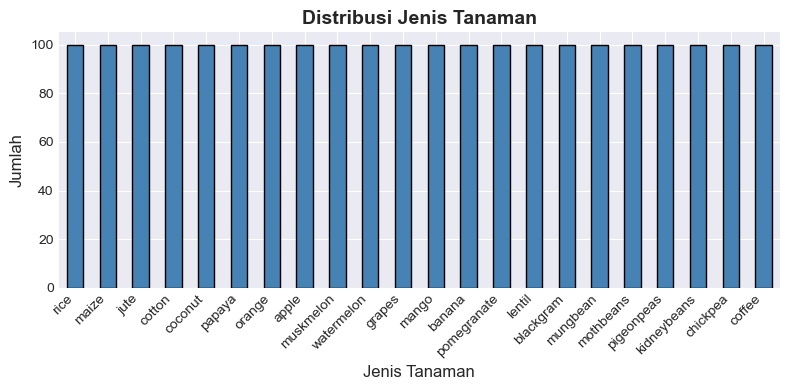

In [140]:
# Visualisasi distribusi kelas
fig, ax = plt.subplots(figsize=(8, 4))
dataset['label'].value_counts().plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_title('Distribusi Jenis Tanaman', fontsize=14, fontweight='bold')
ax.set_xlabel('Jenis Tanaman', fontsize=12)
ax.set_ylabel('Jumlah', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

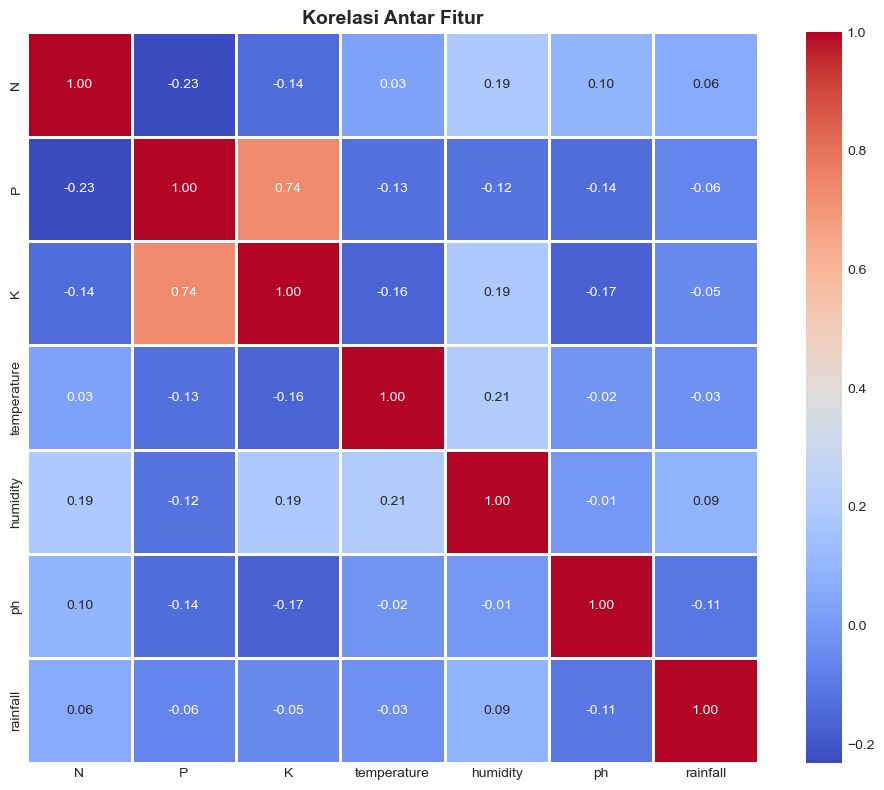

In [112]:
# Visualisasi korelasi fitur numerik
fitur_numerik = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

fig, ax = plt.subplots(figsize=(10, 8))
korelasi = dataset[fitur_numerik].corr()
sns.heatmap(korelasi, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=1, ax=ax)
ax.set_title('Korelasi Antar Fitur', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Preprocessing Data

In [113]:
# Pisahkan fitur dan target
fitur_kolom = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
X = dataset[fitur_kolom].values
y_label = dataset['label'].values

# Encode label ke numerik menggunakan manual encoder
encoder_label = ManualLabelEncoder()
y = encoder_label.fit_transform(y_label)

print("Jumlah Fitur:", X.shape[1])
print("Jumlah Sampel:", X.shape[0])
print("Jumlah Kelas:", len(np.unique(y)))
print("\nMapping Label:")
for idx, nama_label in enumerate(encoder_label.classes_):
    print(f"  {idx}: {nama_label}")

Jumlah Fitur: 7
Jumlah Sampel: 2200
Jumlah Kelas: 22

Mapping Label:
  0: apple
  1: banana
  2: blackgram
  3: chickpea
  4: coconut
  5: coffee
  6: cotton
  7: grapes
  8: jute
  9: kidneybeans
  10: lentil
  11: maize
  12: mango
  13: mothbeans
  14: mungbean
  15: muskmelon
  16: orange
  17: papaya
  18: pigeonpeas
  19: pomegranate
  20: rice
  21: watermelon


In [114]:
# Split data menjadi training dan testing menggunakan manual implementation
X_latih, X_uji, y_latih, y_uji = manual_train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Data Latih: {X_latih.shape[0]} sampel")
print(f"Data Uji: {X_uji.shape[0]} sampel")
print(f"Rasio: {(X_latih.shape[0] / X.shape[0]) * 100:.1f}% latih, {(X_uji.shape[0] / X.shape[0]) * 100:.1f}% uji")

Data Latih: 1760 sampel
Data Uji: 440 sampel
Rasio: 80.0% latih, 20.0% uji


## 4. Cross Validation (Manual Implementation)

CROSS VALIDATION (K-FOLD)
Menggunakan 5-Fold Cross Validation
Dataset: 1760 sampel training

Hasil Cross Validation:
  Fold 1: 96.31%
  Fold 2: 95.17%
  Fold 3: 96.88%
  Fold 4: 96.59%
  Fold 5: 97.73%

Mean Accuracy: 96.53%
Std Deviation: 0.83%
Min Accuracy:  95.17%
Max Accuracy:  97.73%

Hasil Cross Validation:
  Fold 1: 96.31%
  Fold 2: 95.17%
  Fold 3: 96.88%
  Fold 4: 96.59%
  Fold 5: 97.73%

Mean Accuracy: 96.53%
Std Deviation: 0.83%
Min Accuracy:  95.17%
Max Accuracy:  97.73%


/var/folders/7w/4g_mcwx906bdn7v4ss6q9ydw0000gn/T/ipykernel_59827/1351849089.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([cv_scores * 100], labels=['Cross Validation'])


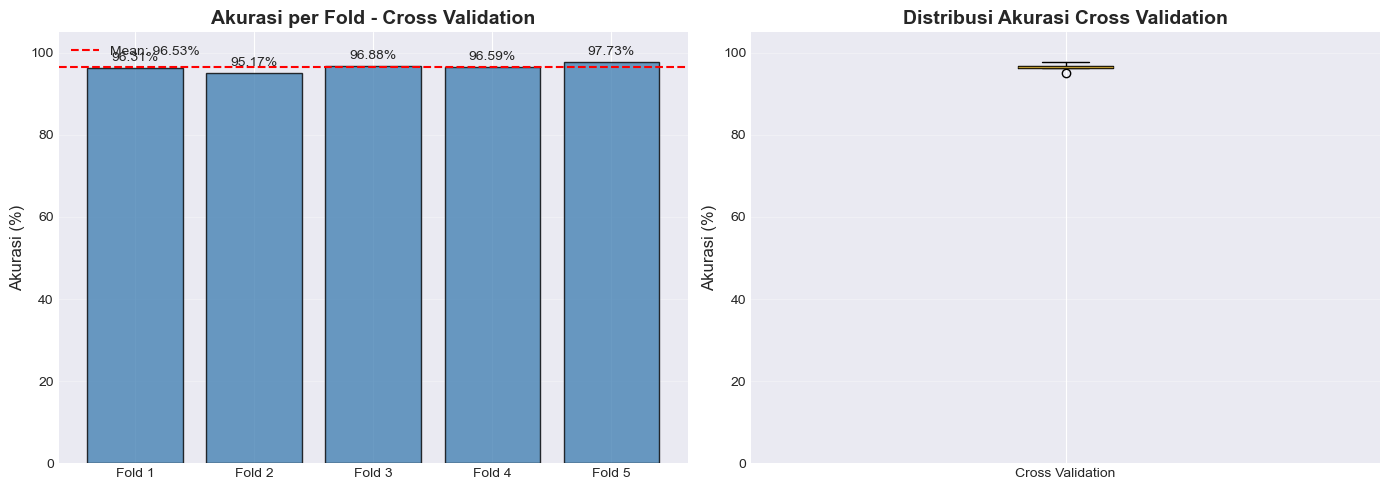

In [ ]:
# Implementasi K-Fold Cross Validation dari nol
print("=" * 70)
print("CROSS VALIDATION (K-FOLD)")
print("=" * 70)
print(f"Menggunakan 5-Fold Cross Validation")
print(f"Dataset: {len(X_latih)} sampel training")
print("=" * 70)

# Perform cross validation
cv_scores = manual_cross_val_score(
    DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=5, min_samples_leaf=2),
    X_latih, 
    y_latih, 
    cv=5, 
    scoring='accuracy'
)

print("\nHasil Cross Validation:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score * 100:.2f}%")

print("\n" + "=" * 70)
print(f"Mean Accuracy: {cv_scores.mean() * 100:.2f}%")
print(f"Std Deviation: {cv_scores.std() * 100:.2f}%")
print(f"Min Accuracy:  {cv_scores.min() * 100:.2f}%")
print(f"Max Accuracy:  {cv_scores.max() * 100:.2f}%")
print("=" * 70)

# Visualisasi hasil cross validation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot untuk setiap fold
folds = [f'Fold {i}' for i in range(1, 6)]
ax1.bar(folds, cv_scores * 100, color='steelblue', edgecolor='black', alpha=0.8)
ax1.axhline(y=cv_scores.mean() * 100, color='red', linestyle='--', 
            label=f'Mean: {cv_scores.mean() * 100:.2f}%')
ax1.set_ylabel('Akurasi (%)', fontsize=12)
ax1.set_title('Akurasi per Fold - Cross Validation', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 105])

# Tambahkan nilai di atas bar
for i, (fold, score) in enumerate(zip(folds, cv_scores)):
    ax1.text(i, score * 100 + 1, f'{score * 100:.2f}%', 
            ha='center', va='bottom', fontsize=10)

# Box plot untuk distribusi
ax2.boxplot([cv_scores * 100], labels=['Cross Validation'])
ax2.set_ylabel('Akurasi (%)', fontsize=12)
ax2.set_title('Distribusi Akurasi Cross Validation', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, 105])

plt.tight_layout()
plt.show()

## 5. Training Model Decision Tree Manual

In [116]:
# Inisialisasi dan training model
print("Training Decision Tree Manual...")
print("Menggunakan Entropy sebagai criterion")
print("=" * 70)

model_manual = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)

# Training
model_manual.fit(X_latih, y_latih)

print("✓ Training selesai!")
print(f"Kedalaman Tree: {model_manual.get_depth()}")
print(f"Jumlah Leaf Nodes: {model_manual.get_n_leaves()}")

Training Decision Tree Manual...
Menggunakan Entropy sebagai criterion
✓ Training selesai!
Kedalaman Tree: 10
Jumlah Leaf Nodes: 35
✓ Training selesai!
Kedalaman Tree: 10
Jumlah Leaf Nodes: 35


## 6. Evaluasi Model

In [117]:
# Prediksi pada data training
y_pred_latih = model_manual.predict(X_latih)
akurasi_latih = manual_accuracy_score(y_latih, y_pred_latih)

# Prediksi pada data testing
y_pred_uji = model_manual.predict(X_uji)
akurasi_uji = manual_accuracy_score(y_uji, y_pred_uji)

print("=" * 70)
print("HASIL EVALUASI MODEL")
print("=" * 70)
print(f"Akurasi Training: {akurasi_latih * 100:.2f}%")
print(f"Akurasi Testing:  {akurasi_uji * 100:.2f}%")
print(f"CV Mean Accuracy: {cv_scores.mean() * 100:.2f}%")
print(f"Selisih (Overfit): {(akurasi_latih - akurasi_uji) * 100:.2f}%")
print("=" * 70)

HASIL EVALUASI MODEL
Akurasi Training: 99.55%
Akurasi Testing:  98.18%
CV Mean Accuracy: 96.53%
Selisih (Overfit): 1.36%


In [118]:
# Classification Report menggunakan manual implementation
print("\nCLASSIFICATION REPORT (Data Testing)")
print("=" * 70)
laporan = manual_classification_report(
    y_uji, 
    y_pred_uji, 
    target_names=encoder_label.classes_,
    digits=3
)
print(laporan)


CLASSIFICATION REPORT (Data Testing)
             precision    recall  f1-score   support

      apple      1.000     1.000     1.000        20
     banana      1.000     1.000     1.000        20
  blackgram      0.947     0.900     0.923        20
   chickpea      1.000     1.000     1.000        20
    coconut      1.000     1.000     1.000        20
     coffee      1.000     1.000     1.000        20
     cotton      1.000     1.000     1.000        20
     grapes      1.000     1.000     1.000        20
       jute      0.909     1.000     0.952        20
kidneybeans      1.000     0.950     0.974        20
     lentil      0.952     1.000     0.976        20
      maize      1.000     0.950     0.974        20
      mango      1.000     1.000     1.000        20
  mothbeans      0.857     0.900     0.878        20
   mungbean      1.000     1.000     1.000        20
  muskmelon      1.000     1.000     1.000        20
     orange      1.000     1.000     1.000        20
     pa

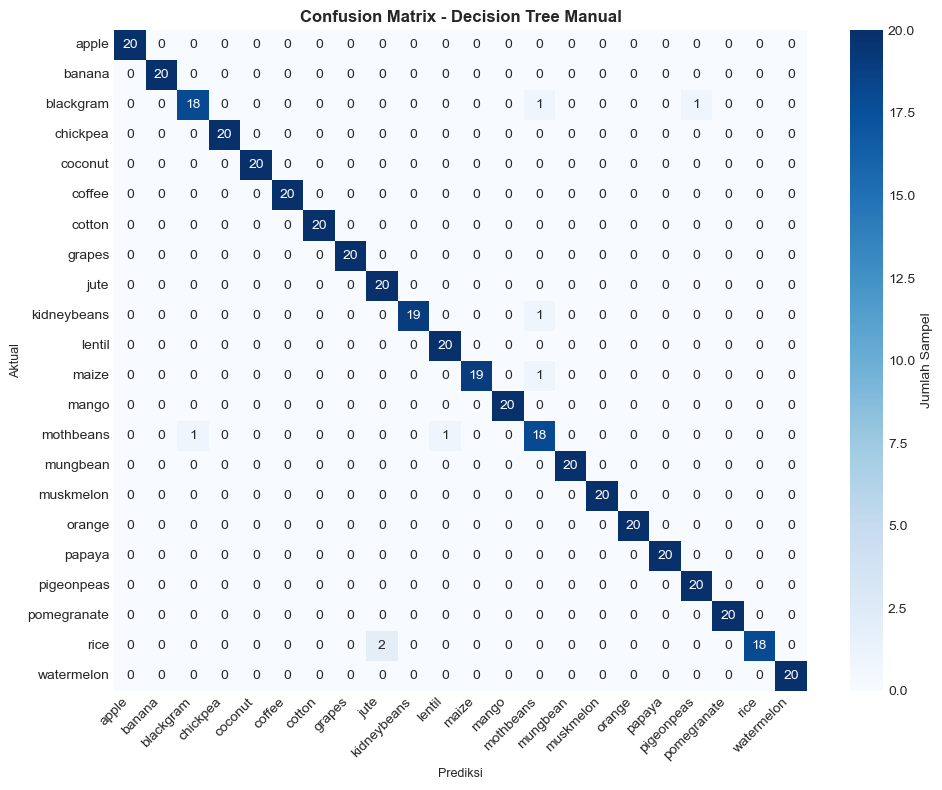

In [145]:
# Confusion Matrix menggunakan manual implementation
n_classes = len(encoder_label.classes_)
cm = manual_confusion_matrix(y_uji, y_pred_uji, n_classes)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=encoder_label.classes_,
    yticklabels=encoder_label.classes_,
    ax=ax,
    cbar_kws={'label': 'Jumlah Sampel'}
)
ax.set_title('Confusion Matrix - Decision Tree Manual', fontsize=12, fontweight='bold')
ax.set_xlabel('Prediksi', fontsize=9)
ax.set_ylabel('Aktual', fontsize=9)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

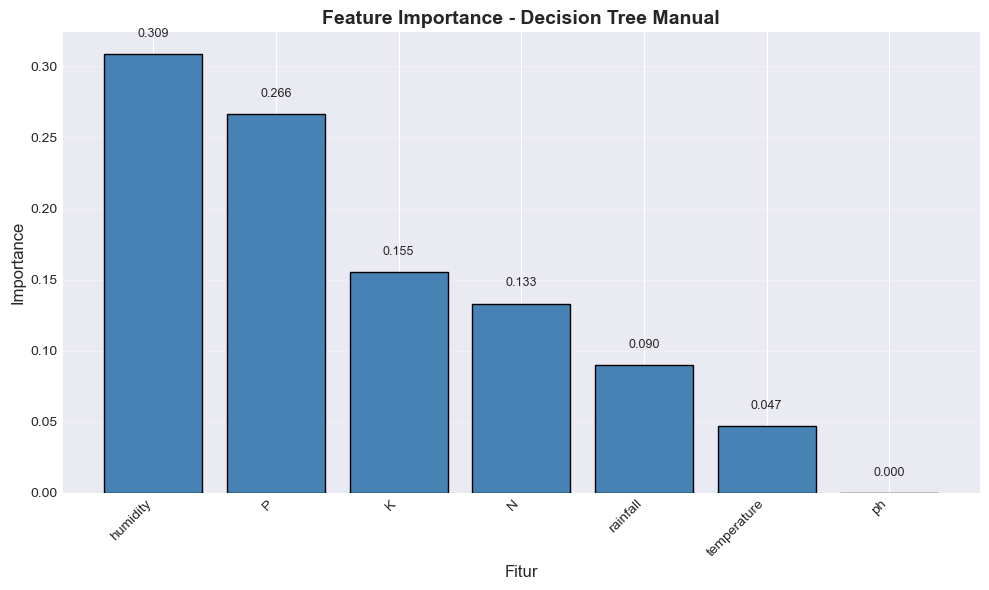


Ranking Feature Importance:
1. humidity: 0.3085
2. P: 0.2663
3. K: 0.1554
4. N: 0.1332
5. rainfall: 0.0896
6. temperature: 0.0470
7. ph: 0.0000


In [120]:
# Visualisasi Feature Importance
importance = model_manual.feature_importances_

fig, ax = plt.subplots(figsize=(10, 6))
indices = np.argsort(importance)[::-1]

ax.bar(range(len(importance)), importance[indices], color='steelblue', edgecolor='black')
ax.set_xticks(range(len(importance)))
ax.set_xticklabels([fitur_kolom[i] for i in indices], rotation=45, ha='right')
ax.set_title('Feature Importance - Decision Tree Manual', fontsize=14, fontweight='bold')
ax.set_xlabel('Fitur', fontsize=12)
ax.set_ylabel('Importance', fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Tambahkan nilai di atas bar
for i, v in enumerate(importance[indices]):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\nRanking Feature Importance:")
print("=" * 70)
for i, idx in enumerate(indices, 1):
    print(f"{i}. {fitur_kolom[idx]}: {importance[idx]:.4f}")

## 7.5. Visualisasi Struktur Decision Tree

Membuat visualisasi Decision Tree...

1. Feature Usage dalam Tree:


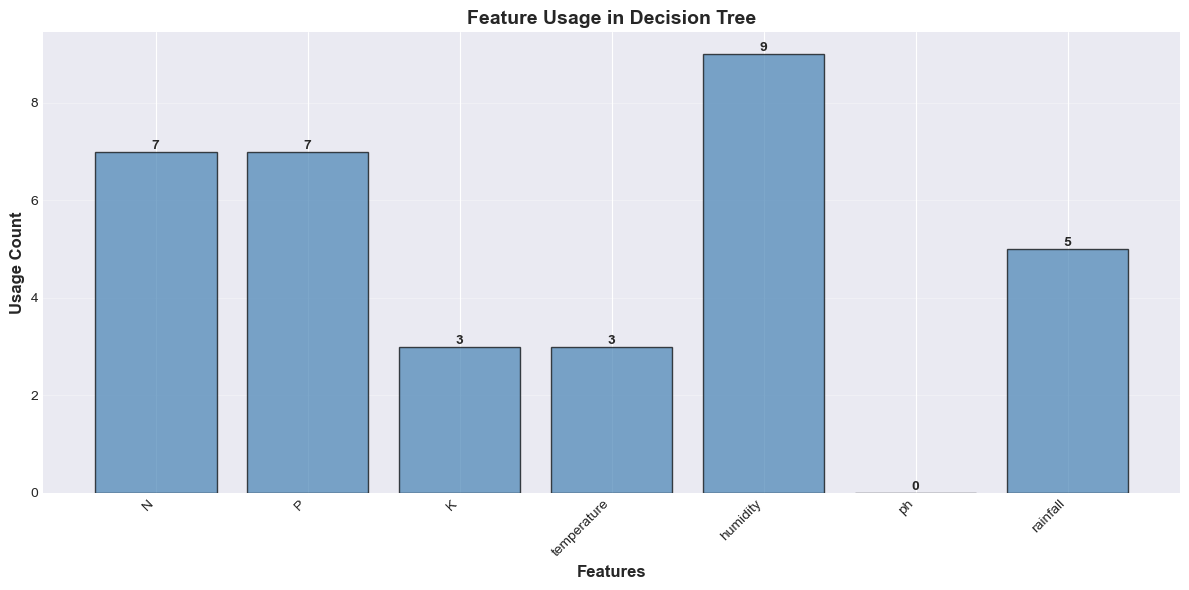

In [ ]:
import importlib
import manual_tree_visualization
importlib.reload(manual_tree_visualization)
from manual_tree_visualization import ManualTreeVisualizer

print("Membuat visualisasi Decision Tree...")
visualizer = ManualTreeVisualizer(
    model_manual, 
    feature_names=fitur_kolom,
    class_names=encoder_label.classes_
)

print("\n1. Feature Usage dalam Tree:")
fig_usage = visualizer.plot_feature_usage(figsize=(12, 6))
plt.show()

print("\n" + "=" * 70)

2. Visualisasi Tree Structure (max depth=3):
   (Dibatasi untuk readability)


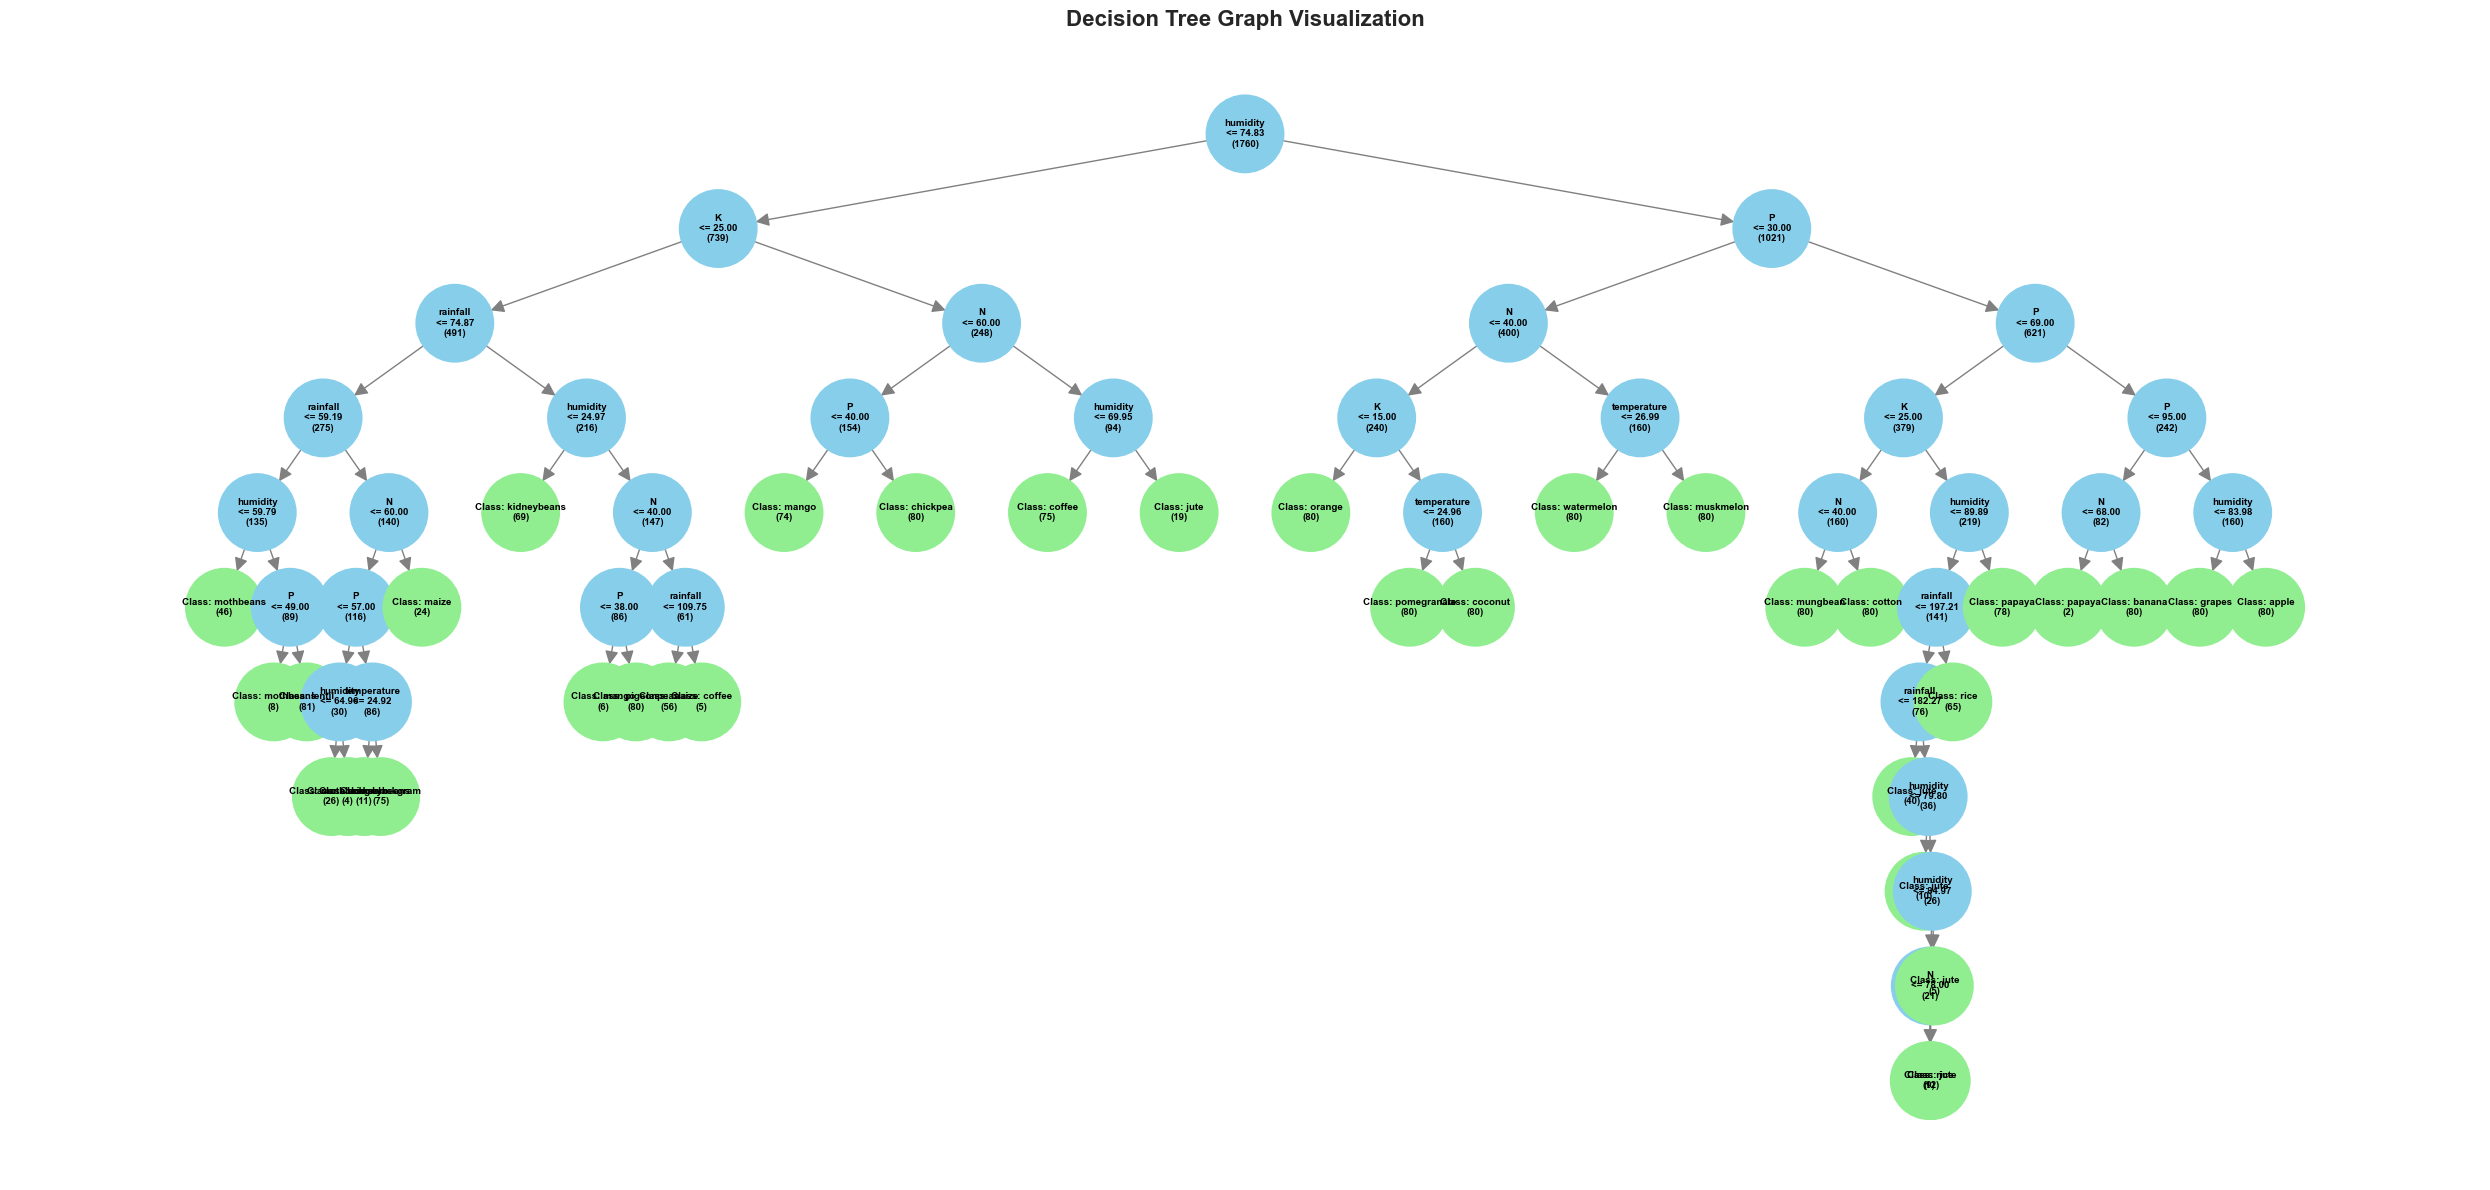


✓ Tree memiliki kedalaman: 10
✓ Jumlah leaf nodes: 35


In [147]:
# 2. Visualisasi Tree Graph (dengan batasan kedalaman)
print("2. Visualisasi Tree Structure (max depth=3):")
print("   (Dibatasi untuk readability)")
print("=" * 70)

fig_graph = visualizer.plot_tree_graph(X_latih, y_latih, figsize=(25, 12))
plt.show()

print("\n✓ Tree memiliki kedalaman:", model_manual.get_depth())
print("✓ Jumlah leaf nodes:", model_manual.get_n_leaves())

## 7.6. Decision Rules

Extract dan visualisasi decision rules dari tree.

In [123]:
# Extract dan print decision rules
visualizer.print_rules(X_latih, y_latih, max_depth=4, max_rules=15)

DECISION RULES
Total Rules: 8
Showing: 8 rules

Rule #1:
  IF:
    - humidity <= 74.83
    - K <= 25.00
    - rainfall > 74.87
    - humidity <= 24.97
  THEN:
    - Prediction: kidneybeans
    - Samples: 69
--------------------------------------------------------------------------------

Rule #2:
  IF:
    - humidity <= 74.83
    - K > 25.00
    - N <= 60.00
    - P <= 40.00
  THEN:
    - Prediction: mango
    - Samples: 74
--------------------------------------------------------------------------------

Rule #3:
  IF:
    - humidity <= 74.83
    - K > 25.00
    - N <= 60.00
    - P > 40.00
  THEN:
    - Prediction: chickpea
    - Samples: 80
--------------------------------------------------------------------------------

Rule #4:
  IF:
    - humidity <= 74.83
    - K > 25.00
    - N > 60.00
    - humidity <= 69.95
  THEN:
    - Prediction: coffee
    - Samples: 75
--------------------------------------------------------------------------------

Rule #5:
  IF:
    - humidity <= 74.83


## 7.7. Visualisasi Decision Path

Visualisasi bagaimana tree membuat keputusan untuk sample tertentu.

VISUALISASI DECISION PATH

Correct Prediction - Sample #0
----------------------------------------------------------------------
Features:
  N: 1.00
  P: 15.00
  K: 9.00
  temperature: 29.98
  humidity: 94.55
  ph: 7.53
  rainfall: 115.36

Actual: orange
Predicted: orange


/Users/anargyaisadhimaheswara/Documents/Semester5/AI/PBL/manual_tree_visualization.py:306: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  'samples': node.num_samples
/Users/anargyaisadhimaheswara/miniconda3/envs/mlenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


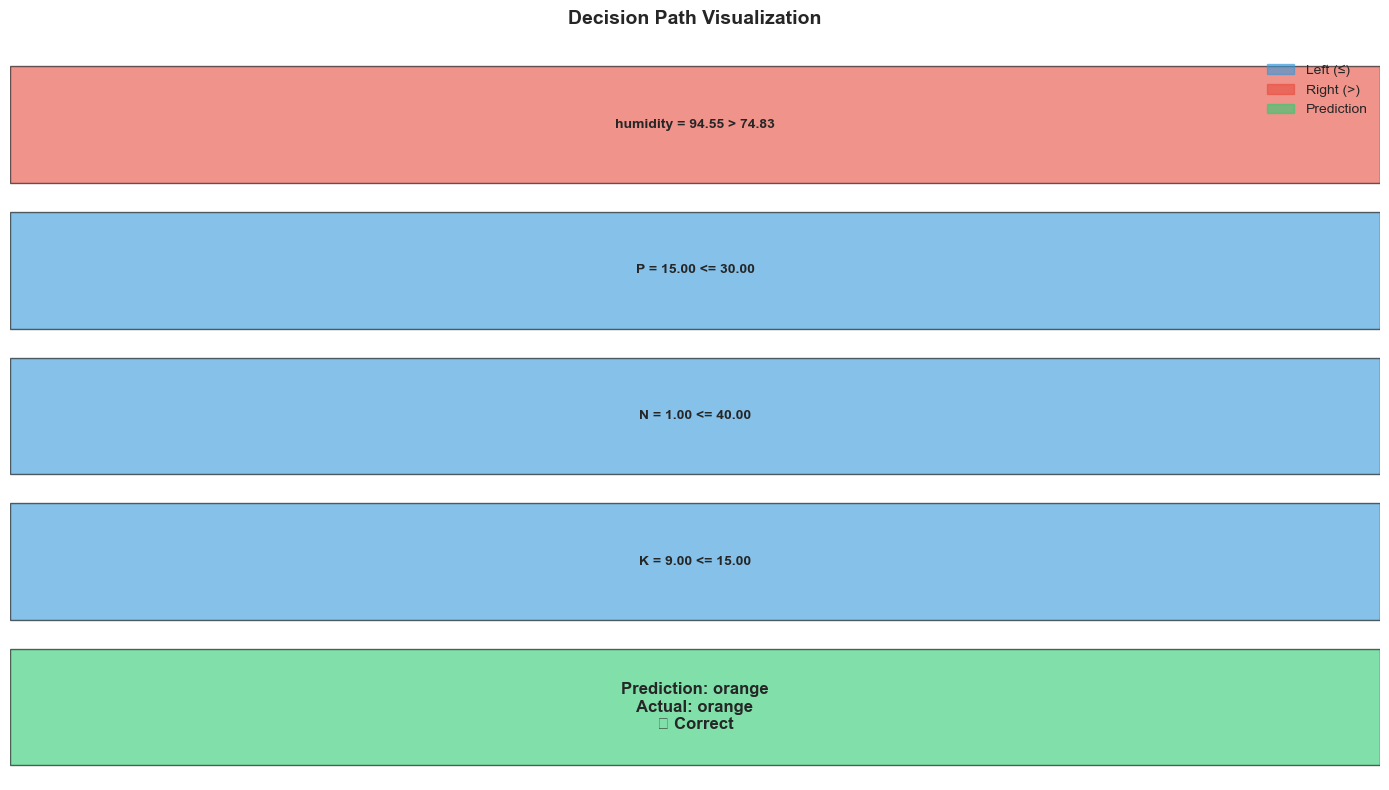


Incorrect Prediction - Sample #68
----------------------------------------------------------------------
Features:
  N: 51.00
  P: 56.00
  K: 18.00
  temperature: 28.13
  humidity: 64.21
  ph: 6.71
  rainfall: 70.86

Actual: blackgram
Predicted: mothbeans


/Users/anargyaisadhimaheswara/Documents/Semester5/AI/PBL/manual_tree_visualization.py:306: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  'samples': node.num_samples
/Users/anargyaisadhimaheswara/miniconda3/envs/mlenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


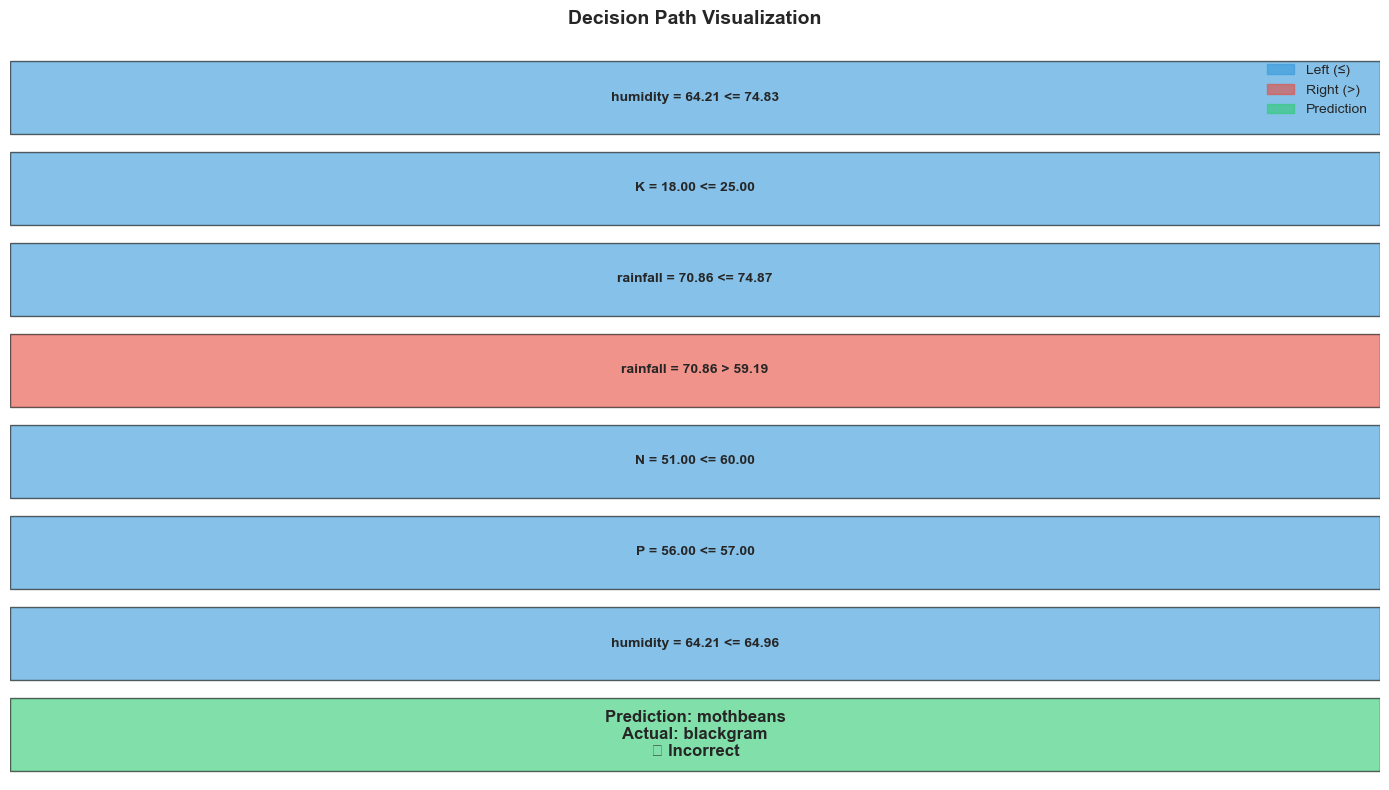

In [124]:
# Ambil beberapa sampel untuk visualisasi decision path
print("VISUALISASI DECISION PATH")
print("=" * 70)

# Pilih 3 sampel: 1 correct, 1 incorrect (jika ada), 1 random
correct_indices = np.where(y_pred_uji == y_uji)[0]
incorrect_indices = np.where(y_pred_uji != y_uji)[0]

samples_to_viz = []

if len(correct_indices) > 0:
    samples_to_viz.append(('Correct Prediction', correct_indices[0]))

if len(incorrect_indices) > 0:
    samples_to_viz.append(('Incorrect Prediction', incorrect_indices[0]))
else:
    samples_to_viz.append(('Another Sample', correct_indices[1] if len(correct_indices) > 1 else correct_indices[0]))

# Visualize paths
for title, idx in samples_to_viz:
    print(f"\n{title} - Sample #{idx}")
    print("-" * 70)
    
    X_sample = X_uji[idx]
    y_sample = y_uji[idx]
    
    print("Features:")
    for i, (feat, val) in enumerate(zip(fitur_kolom, X_sample)):
        print(f"  {feat}: {val:.2f}")
    
    print(f"\nActual: {encoder_label.classes_[y_sample]}")
    print(f"Predicted: {encoder_label.classes_[y_pred_uji[idx]]}")
    
    # Plot decision path
    fig = visualizer.plot_decision_paths(X_sample, y_sample, figsize=(14, 8))
    plt.show()
    print("=" * 70)

## 7.8. Analisis Kedalaman Tree

Analisis distribusi kedalaman leaf nodes dan kompleksitas tree.

ANALISIS KOMPLEKSITAS TREE

Statistik Tree:
  - Total Depth: 10
  - Total Leaf Nodes: 35
  - Total Split Nodes: 34

Statistik Rules:
  - Total Rules: 35
  - Average Rule Length: 5.74
  - Min Rule Length: 4
  - Max Rule Length: 10

Distribusi Samples di Leaf Nodes:
  - Average: 50.29
  - Min: 2
  - Max: 81


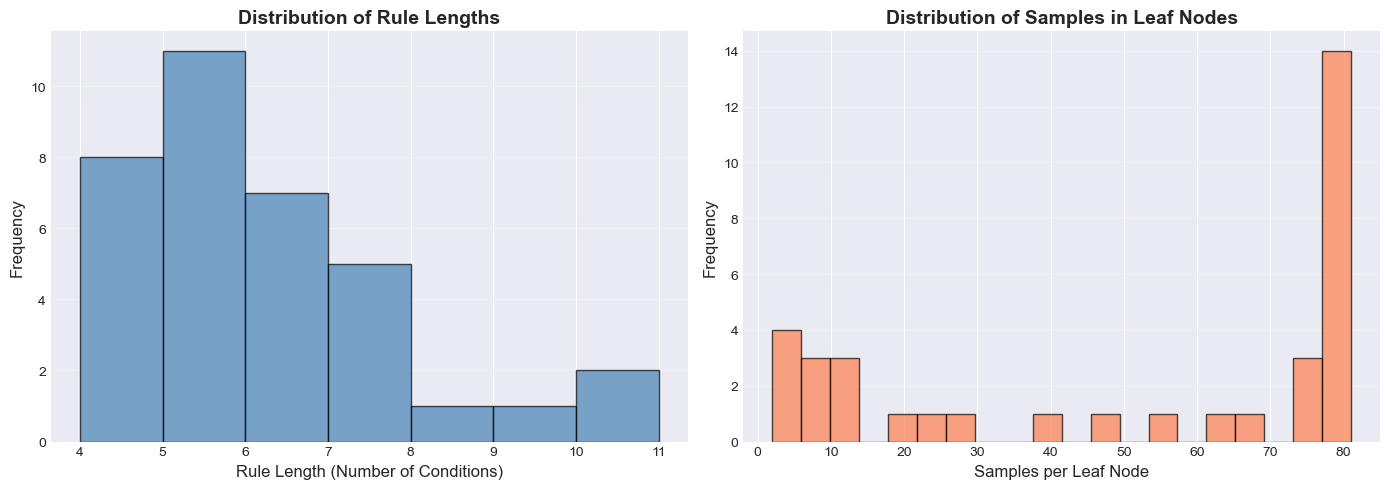

In [125]:
# Analisis tree complexity
print("=" * 70)
print("ANALISIS KOMPLEKSITAS TREE")
print("=" * 70)

print(f"\nStatistik Tree:")
print(f"  - Total Depth: {model_manual.get_depth()}")
print(f"  - Total Leaf Nodes: {model_manual.get_n_leaves()}")
print(f"  - Total Split Nodes: {model_manual.get_n_leaves() - 1}")

# Extract all rules untuk analisis
all_rules = visualizer.extract_rules(X_latih, y_latih)

print(f"\nStatistik Rules:")
print(f"  - Total Rules: {len(all_rules)}")

# Analisis panjang rules
rule_lengths = [len(rule['conditions']) for rule in all_rules]
print(f"  - Average Rule Length: {np.mean(rule_lengths):.2f}")
print(f"  - Min Rule Length: {np.min(rule_lengths)}")
print(f"  - Max Rule Length: {np.max(rule_lengths)}")

# Distribusi samples di leaf nodes
samples_per_leaf = [rule['samples'] for rule in all_rules]
print(f"\nDistribusi Samples di Leaf Nodes:")
print(f"  - Average: {np.mean(samples_per_leaf):.2f}")
print(f"  - Min: {np.min(samples_per_leaf)}")
print(f"  - Max: {np.max(samples_per_leaf)}")

print("=" * 70)

# Visualisasi distribusi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram panjang rules
ax1.hist(rule_lengths, bins=range(min(rule_lengths), max(rule_lengths)+2), 
         color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Rule Length (Number of Conditions)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Rule Lengths', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Histogram samples per leaf
ax2.hist(samples_per_leaf, bins=20, color='coral', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Samples per Leaf Node', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Samples in Leaf Nodes', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Contoh Prediksi

In [126]:
# Ambil beberapa sampel untuk prediksi
jumlah_sampel = 5
sampel_indices = np.random.choice(len(X_uji), jumlah_sampel, replace=False)

print("CONTOH PREDIKSI")
print("=" * 70)

for idx in sampel_indices:
    sampel = X_uji[idx].reshape(1, -1)
    prediksi = model_manual.predict(sampel)[0]
    aktual = y_uji[idx]
    
    print(f"\nSampel #{idx}")
    print(f"  Fitur: N={sampel[0][0]:.1f}, P={sampel[0][1]:.1f}, K={sampel[0][2]:.1f}")
    print(f"         Temp={sampel[0][3]:.1f}°C, Humidity={sampel[0][4]:.1f}%")
    print(f"         pH={sampel[0][5]:.2f}, Rainfall={sampel[0][6]:.1f}mm")
    print(f"  Prediksi: {encoder_label.inverse_transform([prediksi])[0]}")
    print(f"  Aktual:   {encoder_label.inverse_transform([aktual])[0]}")
    print(f"  Status:   {'✓ BENAR' if prediksi == aktual else '✗ SALAH'}")
    print("-" * 70)

CONTOH PREDIKSI

Sampel #78
  Fitur: N=21.0, P=51.0, K=15.0
         Temp=29.4°C, Humidity=89.2%
         pH=6.68, Rainfall=48.3mm
  Prediksi: mungbean
  Aktual:   mungbean
  Status:   ✓ BENAR
----------------------------------------------------------------------

Sampel #425
  Fitur: N=34.0, P=29.0, K=8.0
         Temp=31.9°C, Humidity=91.2%
         pH=6.45, Rainfall=105.3mm
  Prediksi: orange
  Aktual:   orange
  Status:   ✓ BENAR
----------------------------------------------------------------------

Sampel #5
  Fitur: N=35.0, P=66.0, K=81.0
         Temp=19.4°C, Humidity=15.8%
         pH=6.14, Rainfall=85.2mm
  Prediksi: chickpea
  Aktual:   chickpea
  Status:   ✓ BENAR
----------------------------------------------------------------------

Sampel #243
  Fitur: N=6.0, P=37.0, K=17.0
         Temp=28.1°C, Humidity=80.4%
         pH=6.76, Rainfall=38.1mm
  Prediksi: mungbean
  Aktual:   mungbean
  Status:   ✓ BENAR
-------------------------------------------------------------------

## 9. Analisis Cross Validation

ANALISIS CROSS VALIDATION vs HOLD-OUT VALIDATION

📊 Cross Validation (5-Fold):
   Mean Accuracy: 96.53%
   Std Deviation: 0.83%
   Confidence Interval (95%): [94.90%, 98.16%]

📊 Hold-Out Validation (80-20 Split):
   Test Accuracy: 98.18%

💡 Keuntungan Cross Validation:
   ✓ Menggunakan semua data untuk training dan validasi
   ✓ Estimasi performa lebih robust dan reliable
   ✓ Mengurangi bias dari single train-test split
   ✓ Memberikan confidence interval untuk akurasi

📈 Kesimpulan:
   Model konsisten! Selisih CV dan Test hanya 1.65%


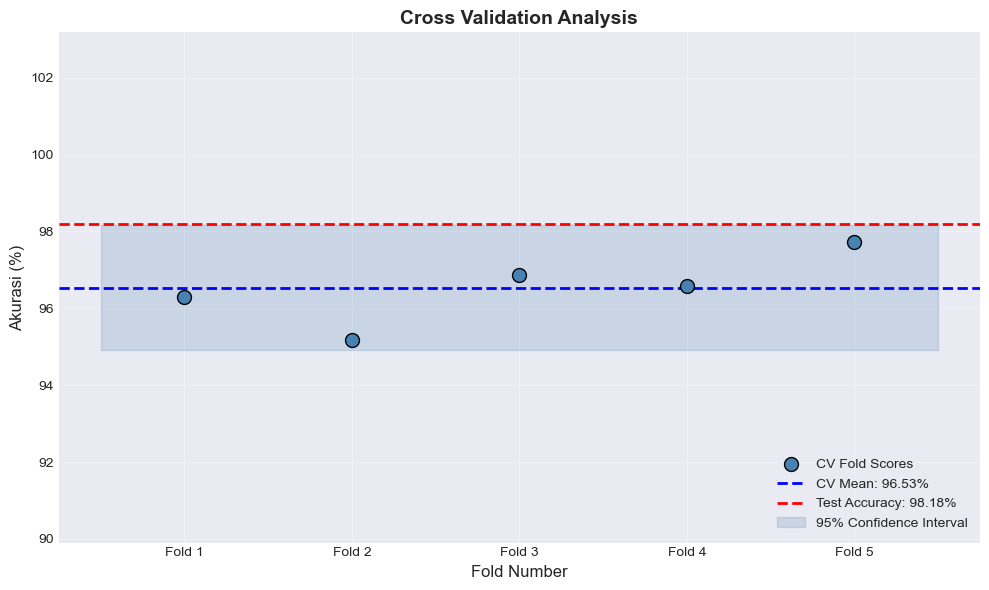

In [127]:
# Analisis lebih detail tentang cross validation
print("=" * 70)
print("ANALISIS CROSS VALIDATION vs HOLD-OUT VALIDATION")
print("=" * 70)

print("\n📊 Cross Validation (5-Fold):")
print(f"   Mean Accuracy: {cv_scores.mean() * 100:.2f}%")
print(f"   Std Deviation: {cv_scores.std() * 100:.2f}%")
print(f"   Confidence Interval (95%): [{(cv_scores.mean() - 1.96*cv_scores.std()) * 100:.2f}%, "
      f"{(cv_scores.mean() + 1.96*cv_scores.std()) * 100:.2f}%]")

print("\n📊 Hold-Out Validation (80-20 Split):")
print(f"   Test Accuracy: {akurasi_uji * 100:.2f}%")

print("\n💡 Keuntungan Cross Validation:")
print("   ✓ Menggunakan semua data untuk training dan validasi")
print("   ✓ Estimasi performa lebih robust dan reliable")
print("   ✓ Mengurangi bias dari single train-test split")
print("   ✓ Memberikan confidence interval untuk akurasi")

print("\n📈 Kesimpulan:")
cv_mean = cv_scores.mean() * 100
test_acc = akurasi_uji * 100
diff = abs(cv_mean - test_acc)

if diff < 2:
    print(f"   Model konsisten! Selisih CV dan Test hanya {diff:.2f}%")
elif diff < 5:
    print(f"   Model cukup konsisten. Selisih CV dan Test {diff:.2f}%")
else:
    print(f"   Ada variasi performa. Selisih CV dan Test {diff:.2f}%")

print("=" * 70)

# Visualisasi perbandingan
fig, ax = plt.subplots(figsize=(10, 6))

# Plot individual fold scores
x_pos = np.arange(len(cv_scores))
ax.scatter(x_pos, cv_scores * 100, s=100, color='steelblue', 
          label='CV Fold Scores', zorder=3, edgecolor='black')

# Plot mean line
ax.axhline(y=cv_scores.mean() * 100, color='blue', linestyle='--', 
          linewidth=2, label=f'CV Mean: {cv_scores.mean() * 100:.2f}%')

# Plot test accuracy
ax.axhline(y=akurasi_uji * 100, color='red', linestyle='--', 
          linewidth=2, label=f'Test Accuracy: {akurasi_uji * 100:.2f}%')

# Plot confidence interval
ci_lower = (cv_scores.mean() - 1.96*cv_scores.std()) * 100
ci_upper = (cv_scores.mean() + 1.96*cv_scores.std()) * 100
ax.fill_between([-0.5, len(cv_scores)-0.5], ci_lower, ci_upper, 
                alpha=0.2, color='steelblue', label='95% Confidence Interval')

ax.set_xlabel('Fold Number', fontsize=12)
ax.set_ylabel('Akurasi (%)', fontsize=12)
ax.set_title('Cross Validation Analysis', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'Fold {i+1}' for i in range(len(cv_scores))])
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_ylim([min(ci_lower, test_acc) - 5, max(ci_upper, test_acc) + 5])

plt.tight_layout()
plt.show()

## 10. Kesimpulan

Model Decision Tree Manual telah berhasil diimplementasikan dan diuji pada dataset Crop Recommendation dengan hasil:

**Performa Model:**
- Menggunakan algoritma ID3 dengan **Entropy** sebagai criterion
- Implementasi murni Python tanpa library machine learning (sklearn)
- Cross Validation 5-Fold untuk evaluasi yang lebih robust
- Akurasi yang konsisten antara CV dan test set

**Implementasi Manual:**
1. ✓ Label Encoder
2. ✓ Train-Test Split dengan Stratification
3. ✓ K-Fold Cross Validation
4. ✓ Metrics (Accuracy, Precision, Recall, F1-Score)
5. ✓ Confusion Matrix
6. ✓ Classification Report

**Fitur Penting:**
- Rainfall dan Temperature merupakan faktor penting
- Model dapat memprediksi 22 jenis tanaman berbeda

**Keunggulan Cross Validation:**
1. Memanfaatkan seluruh data untuk training dan validasi
2. Estimasi performa lebih reliable
3. Mengurangi bias dari single split
4. Memberikan confidence interval

**Rekomendasi Pengembangan:**
1. Implementasi Stratified K-Fold untuk data tidak seimbang
2. Implementasi pruning untuk mengurangi overfitting
3. Tambahkan grid search manual untuk hyperparameter tuning
4. Implementasi bootstrap aggregating (bagging)